In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

In [28]:

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['https', 'http', 'www', 'com', 'org', '.md',
    # Git terms
    'blob', 'master', 'branch', 'commit', 'merge',
    # Project metadata
    'version', 'build', 'install', 'license', 'readme',
    # Placeholder terms
    'placeholder', 'example', 'template',
    # Programming-specific terms
    'code', 'function', 'module', 'script',
    # Others
    'img', 'badge', 'shield', 'status', "name", "github"
])

In [2]:
input_file = "../../rs_usage/info_repos/readme/readme.csv"
readme = pd.read_csv(input_file, low_memory=False)
with open('../data/readme.npy', 'wb') as f:
    np.save(f, readme.values)

In [3]:
readme = np.load('../data/readme.npy', allow_pickle=True)
readme = pd.DataFrame(readme, columns=["id", "readme"])
readme["readme"] = np.where(readme["readme"]=="Error: Unable to retrieve README for url. Status code: 404", np.nan, readme["readme"])

In [4]:
def str2byte(a):
    try:
        return len(a.encode('utf-8'))
    except AttributeError:
        if math.isnan(a):
            return 0
        else:
            print(f"Unable to compute size of string for {a}")


def classify_size(size):
    if size == 0:
        return "no"
    elif size <= 1500:
        return "short"
    elif 1500 < size < 10000:
        return "detailed"
    else:
        return "informative"

In [5]:
readme["size"] = readme["readme"].apply(str2byte)

In [23]:
detail_level = [classify_size(size) for size in readme["size"]]
categories, counts = np.unique(detail_level, return_counts=True)
all_readmes = " ".join(readme["readme"].dropna())
headings = re.findall(r'^(#+)\s+(.+)', all_readmes, flags=re.MULTILINE)
headings = " ".join(np.asarray(headings)[:, 1])

In [29]:
wordcloud = WordCloud(
    width=480,
    height=240,
    background_color='white',
    max_words=50,
    colormap='viridis',
    stopwords=custom_stopwords
).generate(headings)

In [39]:
all_readmes = " ".join(readme["readme"].dropna())
dois = re.findall('https?://doi\.org/[0-9.]+/[^\s]+', all_readmes, flags=re.MULTILINE)

In [71]:
def has_doi(a):
    try:
        x = re.findall('https?://doi\.org/[0-9.]+/[^\s]+', a, flags=re.MULTILINE)
    except TypeError:
        if math.isnan(a):
            return False
    return bool(x)

In [72]:
readme["has_doi"] = readme["readme"].apply(has_doi)
doi_categories, doi_counts = np.unique(readme["has_doi"], return_counts=True)

Text(0.5, 1.0, 'Word Cloud of README headings')

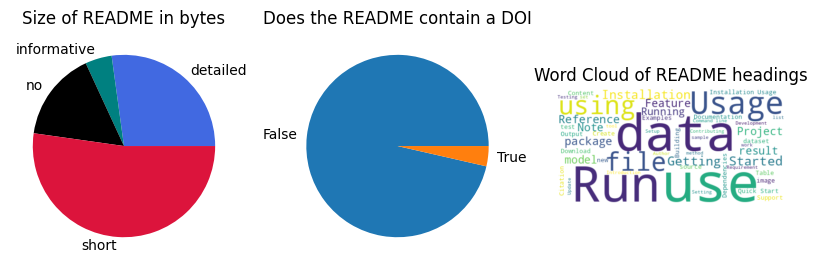

In [76]:
fig, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].pie(counts, labels=categories, colors=["royalblue", "teal", "k", "crimson"])
axs[0].set_title("Size of README in bytes")
axs[1].pie(doi_counts, labels=doi_categories)
axs[1].set_title("Does the README contain a DOI")
axs[2].imshow(wordcloud, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title("Word Cloud of README headings")
